# House pricing model
In this notebook we produce a linear regression model from price.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import RegressionAnalysis

## Load cleaned data and exclude prices above 2,000,000 USD.

In [2]:
dfA = pd.read_csv('data/cleaned.csv')
df = dfA.query('price < 2*10**6')

## Compute log price

In [3]:
y = df[['price']].apply(np.log10)
y.columns = ['log_price']

## Box-Cox transform of living space for nearest neighbors

In [4]:
bc_living15, bc_living15_lambda = stats.boxcox(df['sqft_living15'])
print(f'$\lambda = {round(bc_living15_lambda,2)}$')

$\lambda = -0.21$


## Box-Cox transform of bedrooms per square foot of living space
Removed from model due to linear dependence issues.

In [5]:
bed_density = df['bedrooms'] / df['sqft_living']
bc_bed_density, bc_bed_density_lambda = stats.boxcox(bed_density)
print(f'$\lambda = {round(bc_bed_density_lambda,2)}$')

$\lambda = 0.21$


## Box-Cox transform of bathrooms per bedroom

In [6]:
bath_bed_ratio = df['bathrooms'] / df['bedrooms']
bc_bath_bed_ratio, bc_bath_bed_ratio_lambda = stats.boxcox(bath_bed_ratio)
len(bc_bath_bed_ratio)

21389

## Dummy variables for low, medium, and high median price by zip code.

In [7]:
zip_medians = df[['zipcode', 'price']].groupby(by='zipcode').agg('median')
q1, q2 = zip_medians['price'].quantile(q=[1/3, 2/3])
def get_zip_category(price):
    if price < q1:
        category = 'low'
    elif price < q2:
        category = 'med'
    else:
        category = 'high'
    return category
zip_medians['category'] = zip_medians['price'].apply(get_zip_category)
zip_category_map = zip_medians['category'].to_dict()
zip_categories = df['zipcode'].apply(lambda x: zip_category_map[x])
zip_cat_dummies = pd.get_dummies(zip_categories, drop_first=True, prefix='zipcode')

## Box-Cox transform of square feet of lot per square foot of living area.

In [8]:
lot_ratio = df['sqft_lot'] / df['sqft_living']
bc_lot_ratio, bc_lot_ratio_lambda = stats.boxcox(lot_ratio)
print(f'$\lambda = {round(bc_lot_ratio_lambda,2)}$')

$\lambda = -0.24$


## Make data frame of variables for regression

In [9]:
X = None
X = zip_cat_dummies
X['bc_living15'] = bc_living15
#X['bc_bed_density'] = bc_bed_density
X['bc_bath_bed_ratio'] = bc_bath_bed_ratio
#X['bc_lot_ratio'] = bc_lot_ratio
#X['grade'] = df['grade']
data = pd.concat([X,y], axis=1)

## Instantiate model

In [10]:
model = RegressionAnalysis.Model(data=data, target='log_price')

## Produce a pair plot of all selected model variables
Below we see that input variables do not exhibit any excessively non-linear relationships with the target. Continuous variables are reasonably uncorrelated.
### Linear relationship hypothesis: Satisfied

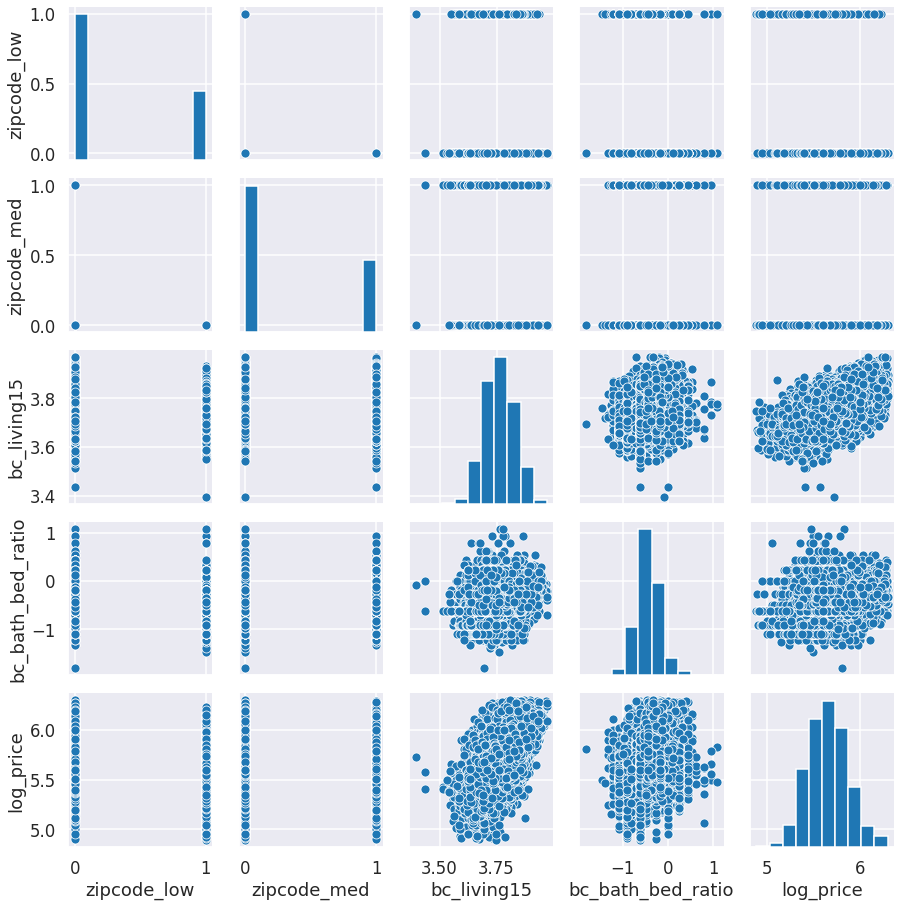

In [11]:
pair_plot = model.make_pair_plot()
#uncomment the line below to save the pair plot.
#pair_plot.savefig('../images/pair_plot.png')

## Plot residuals against inputs
Below we see that residuals are relatively unstructured when plotted against input variables.

### Residuals independent of inputs hypothesis: Satisfied

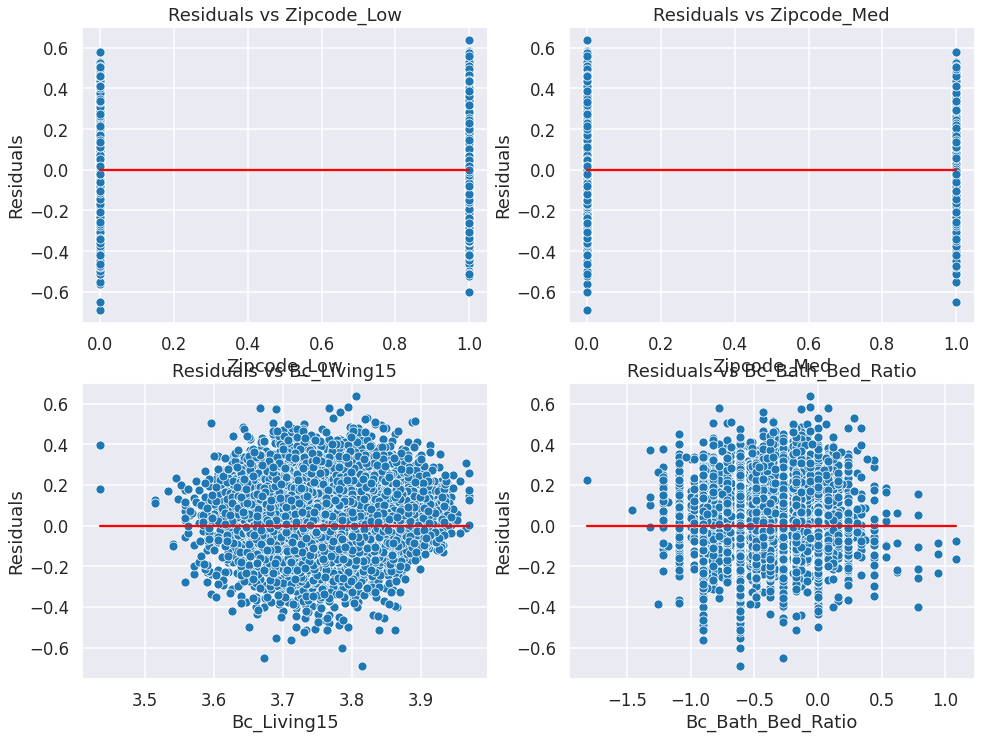

In [12]:
inputs_residuals_plot = model.plot_residuals_against_inputs()

## Plot residuals against predicted values
Below we see that residuals are relatively unstructured when plotted against predicted values.

### Uniform variance of residuals hypothesis: Satisfied

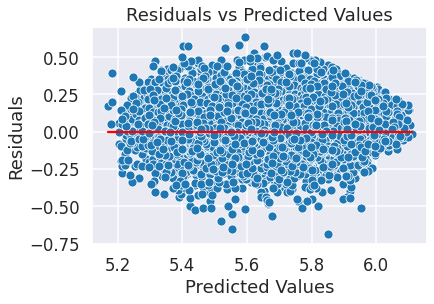

In [13]:
predictions_residuals_plot = model.plot_residuals_against_prediction()

## Plotting distribution and QQ plot of residuals
Below we see that our residuals are fairly symmetric, however they are slightly too heavy-tailed to be described by a normal distribution.

### Normality of residuals hypothesis: Not satisfied
This means that hypothesis testing for parameters and model validity may not be justified without adjusting the sampling distribution.

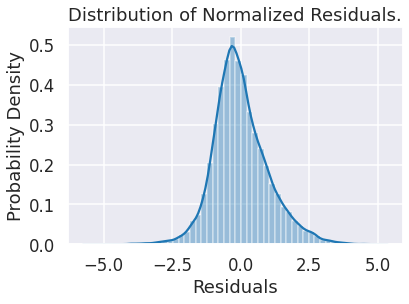

In [14]:
residual_distirbution_plot = model.plot_residuals_distribution()

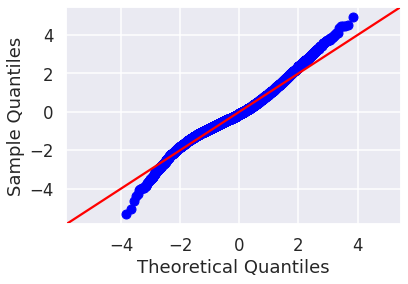

In [15]:
residual_qq_plot = model.plot_residuals_normal_qq()

## Compute variance inflation factors for each input variable
Below we see that all vif scores are below 5 for this model 

### Linearly independent inputs hypothesis: Satisfied

In [16]:
model.compute_vif()

{'zipcode_low': 1.95,
 'zipcode_med': 1.97,
 'bc_living15': 4.71,
 'bc_bath_bed_ratio': 3.56}

## Compairing training and testing $R^2$ values
Below we see that, while $R^2$ is lower than we would like, it is very consistent between training and testing data.

### Model generalizes hypothesis: Satisfied

### Compute training $R^2$
Below we see that our model describes 64% of the variance in log price for the training data.

In [17]:
model.model.score(model.X_train, model.y_train)

0.6469466511436766

### Compute test $R^2$
Below we see that our model describes 62% of the variance in log price for the testing data.

In [18]:
model.model.score(model.X_test, model.y_test)

0.6232592576017179

## Price residuals
Since we modeled log price we transform our model back to price and compute residuals. We see that our model will tend to under estimate the price of a house. This should be expected since exponentiation magnifies differences in large values more than differences in small values.

In [19]:
price_res_train = 10**model.y_train - 10**model.y_hat_train

## Price root mean squared error
Below we see that our root mean squared error is large (190,000 USD), but it is consistent between the training and testing data. 

In [20]:
train_mse = mean_squared_error(10**model.y_train, 10**model.y_hat_train)
test_mse = mean_squared_error(10**model.y_test, 10**model.y_hat_test)
print('Train Root Mean Squarred Error:', np.sqrt(train_mse))
print('Test Root Mean Squarred Error:', np.sqrt(test_mse))

Train Root Mean Squarred Error: 188059.04980093945
Test Root Mean Squarred Error: 198034.01894235815


## General model evaluation
Below we see that all of our parameters are significant, however we should be suspicious of these test since they rely on normality of the residuals. Having said that, the t-statistics are all very large as is our sample size, so slightly heavy tails on the residual distribution are unlikely to change significance for any of our parameters.

We also note that the sign and magnitude of the parameters is consistent with intuition.

### Normality of residuals hypothesis: Side-stepped??

In [22]:
X1_train = sm.add_constant(model.X_train)
model = sm.OLS(model.y_train, X1_train, hasconst=True).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     7836.
Date:                Wed, 14 Oct 2020   Prob (F-statistic):               0.00
Time:                        16:56:43   Log-Likelihood:                 10800.
No. Observations:               17111   AIC:                        -2.159e+04
Df Residuals:                   17106   BIC:                        -2.155e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3697      0.061      6.034      0.000       0.250       0.490
zipcode_low          -0.2871      0.002   -115.207      0.000      -0.292      -0.282
zipcode_med          -0.1163      0.002    -47.546      0.000      -0.121      -0.111
bc_living15           1.4489      0.016     90.145      0.000       1.417       1.480
bc_bath_bed_ratio     0.0766      0.004     20.831      0.000       0.069       0.084
==============================================================================
Omnibus:                      965.756   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1655.958
Skew:                           0.449   Prob(JB):                         0.00
Kurtosis:                       4.231   Cond. No.                         254.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Conclusion
Our model suffers from non-normality of the residuals, however it is unlikely that this actually threatens validity of the model. The larger issue is that the model does not predict price particularly well. Both $R^2$ and root mean squared error indicate that this model cannot provide precise predictions of price.

## The model is sound but not good.

# Future Work
 * Incorporate lat-lon data
 * Clean up regression class
 * Investigate significance tests with non-normal residuals